### Convolutional AutoEncoder(합성곱 오토인코더)
1. 원리 
    - 압축하는 인코더 부분은 그대로 사용해도 문제가 없음 
    - 하지만 디코더부분이 인코더와 대칭되게 만들기 위해서는 전치 합성곱을 해야함 
2. 전치 합성곱(Transposed Convolution)
    - 하나의 입력값을 받아 여기에 서로 다른 가중치를 곱해 필터의 크기만큼 입력값을 '퍼뜨리틑' 역할을 함 
    - ex) 3*3 전치 합성곱 연산을 1*1 입력에 대해 연산하면 각 가중치와 입력이 곱해지고 편차가 더해진 값으로 나오게 됨
    - 합성곱 연산은 필터에 맞게 데이터가 얼마나 비슷한지를 나타내는데 반해 전치 합성곱은 가중치가 입력과 곱해지는 방식 
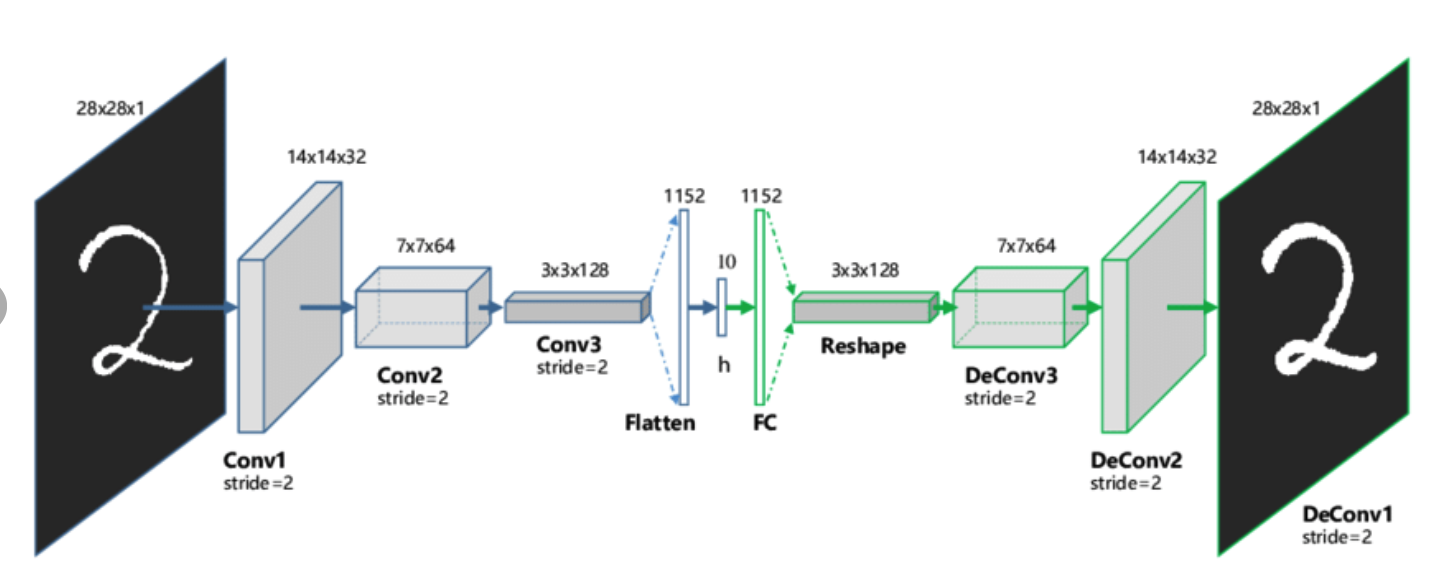

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

### Set HyperParaMeter

In [2]:
batch_size= 256
learning_rate = 0.0002
num_epoch = 5

### Data

In [3]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

### DataLoader

In [4]:
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

### Model 

In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.layer1 = nn.Sequential(
        nn.Conv2d(1, 16, 3, padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Conv2d(16, 32, 3, padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 64, 3, padding = 1), 
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2, 2))
        
        self.layer2 = nn.Sequential(
        nn.Conv2d(64, 128, 3, padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(128, 256, 3, padding = 1),
        nn.ReLU())
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out 

In [6]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, 2, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(64, 16 ,3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 1, 3, 2, 1, 1),
            nn.ReLU()
        )
        
    def forward(self, x):
        out = x.view(batch_size, 256, 7, 7)
        out = self.layer1(out)
        out = self.layer2(out)
        return out 
        

### Loss Function & Optimizer 

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(device)

encoder = Encoder().to(device)
decoder = Decoder().to(device)

parameters = list(encoder.parameters()) + list(decoder.parameters())

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr = learning_rate)

cpu


### Train

In [8]:
try:
    encoder, decoder = torch.load('./model/conv_autoencoder.pkl')
    print('\n ---------------- model restored ----------------\n')
except:
    print('\n ---------------- model not restored ----------------\n')
    pass 

for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader):
        optimizer.zero_grad()
        image = image.to(device)
        
        output = encoder(image)
        output = decoder(output)
        
        loss = loss_func(output, image)
        loss.backward()
        optimizer.step()
        
    if j % 10 ==0:
        torch.save([encoder, decoder], './model/conv_autoencoder.pkl')
        print(loss)



 ---------------- model not restored ----------------



### Check

torch.Size([256, 28, 28])


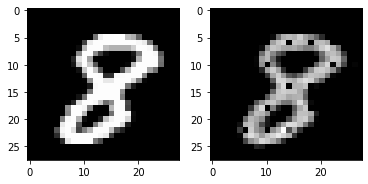

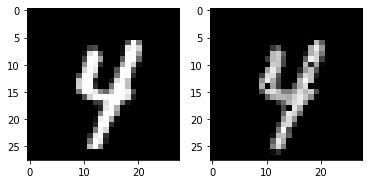

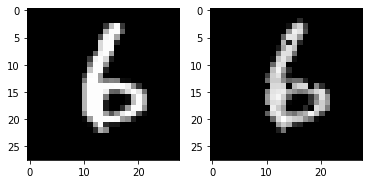

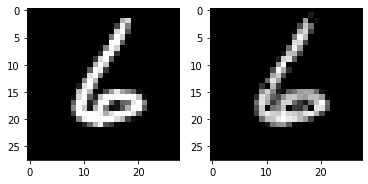

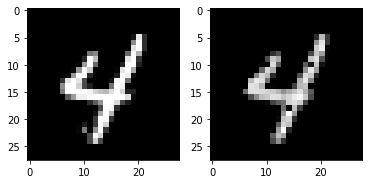

In [9]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1, 2, 1)
    plt.imshow(torch.squeeze(image[i]).cpu().numpy(), cmap = 'gray')
    plt.subplot(1, 2, 2)
    plt.imshow(out_img[i].numpy(), cmap = 'gray')
    plt.show()

In [10]:
with torch.no_grad():
    for j, [image, label] in enumerate(test_loader):
        
        image = image.to(device)
        output = encoder(image)
        output = decoder(output)
        
    if j % 10 == 0:
        print(loss)

torch.Size([256, 28, 28])


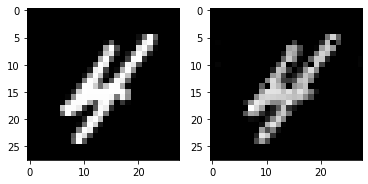

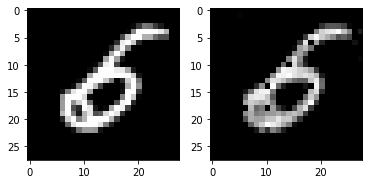

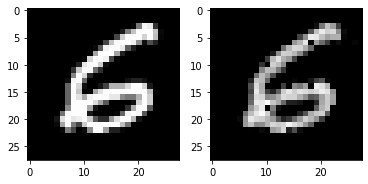

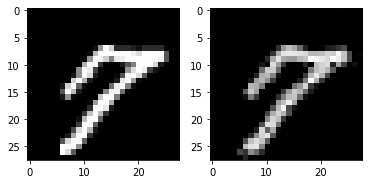

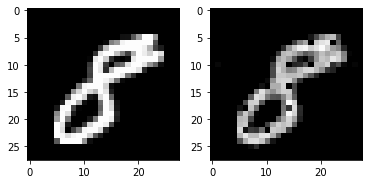

In [12]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1, 2, 1)
    plt.imshow(torch.squeeze(image[i]).cpu().numpy(), cmap = 'gray')
    plt.subplot(1, 2, 2)
    plt.imshow(out_img[i].numpy(), cmap = 'gray')
    plt.show()

#### 출처 
1. https://www.researchgate.net/figure/The-structure-of-proposed-Convolutional-AutoEncoders-CAE-for-MNIST-In-the-middle-there_fig1_320658590